
# Float vertical position control, realistic float behavior


---

## Equations of motion

Equations governing the float behavior are taken from P. Lherminier thesis (Annex 3, [link](http://www.google.com)):
which is strongly inspired from Voorhis (1971) (link).
They may account for water motions.
We ignore rotational dynamics which is less relevant when the float is not equipped with propellers.

Central variables are:
- $z_f$ : float vertical position
- $z_w$ : water vertical position
- $z_r=z_w-z_f$: water vertical position with respect to the float position

Corresponding velocities are:
$w_f=\frac{dz_f}{dt}$, $w=\frac{dz_w}{dt}$, $w_r=w-w_f$

The dynamical equation ruling the float vertical displacement is:
$$
\begin{align}
m \frac{d^2z_f}{dt^2} = m \frac{dw_f}{dt} = \Pi - mg - D,
\end{align}
$$
where:
- $\Pi$ represents the vertical component induced by pressure forces on the float.
- $D$ is the vertical force exerted by viscous drag forces.

Pressure forces are decomposed into one contribution due to pressure fields in the absence of the float
($\Pi_0$) and one contribution associated with disruptions of the flow by the float ($\Pi'$).

$$
\begin{align}
\Pi_0 &= -V\partial_z p = -\frac{m}{\rho_f} \partial_z p \\
&= \frac{mg\rho_w}{\rho_f} + m \frac{\rho_w}{\rho_f} \frac{Dw}{Dt}
\end{align}
$$
where $Dw/Dt$ is the vertical acceleration of water.
Densities are given by the float and water equations of state which may be linearized or not:
$$
\begin{align}
\rho_w &= \rho_w(p,T,S) \\
\rho_f &= \rho_f(p,T) = \frac{m}{V(T,P)+v}\\
\end{align}
$$
where $V$ represents the bulk of the float volume that may be affected by pressure and temperature and $v$ is the volume taken in and out by the pump.

For large water motions with respect to float length, disruptions of the pressure field by the float lead to a drag that is proportional to the square of relative velocity:
$$
\begin{align}
\Pi' &= \frac{m}{L_v} \Big | \frac{dz_r}{dt} \Big | \frac{dz_r}{dt},
\end{align}
$$
where $L_v$ is a drag lengthscale that is comparable to the length of the float $L_f$.
Not that if water is still: $z_r=-z_f$.

We ignore viscous forces for now.

Assumptions:
- the float follows horizontal motions exactly
- no viscous forces

Additional assumptions made in this notebook: 
- instantaneous thermal equilibrium



---

---

$$
\begin{align}
\partial_t d &= v \\
m\partial_t v &= mg - \rho_0 l^2 \max(0,l+\min(d,0))~g -\frac{1}{2} \rho_0 v |v| l^2 c_x \\ 
\partial_t b &= u
\end{align}
$$

where $d$ is the depth, $v$ is downward velocity, $l$ is the float width, $m$ its mass
with $m = (1+\beta b)\rho_0 l^3$, $\beta$ is a constant.

$c_w=O(1)$

---

---

In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cartopy.crs as ccrs
import numpy as np
from scipy.interpolate import interp1d
import time

from matplotlib import animation, rc
from IPython.display import HTML

from netCDF4 import Dataset

import gsw

Float parameters: 
  L      =0.40 m      - float length
  a      =0.05 m      - float radius
  m      =3.14 kg     - float radius
  gamma  =2.00e-06 /dbar  - mechanical compressibility
  alpha  =7.00e-05 /dbar  - mechanical compressibility

Density at the surface = 1000.000000
Density at 1000dbar = 1002.004008
WOA water profile at lon=-50, lat=40


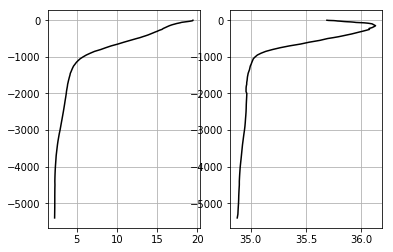

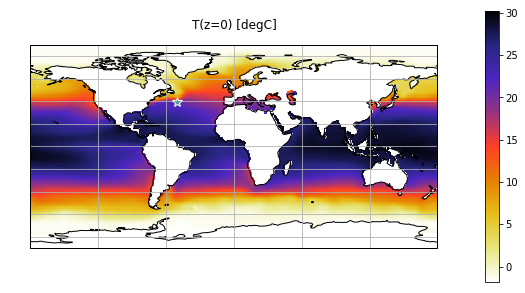

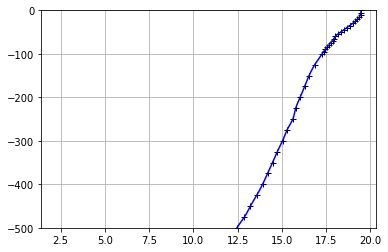

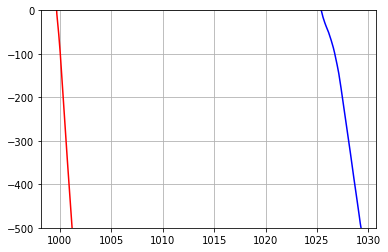

In [10]:
class afloat():
    
    def __init__(self,**kwargs):
        # default parameters
        pdefault = {'a': 0.05, 'L': 0.4, 'gamma': 2.e-6, 'alpha': 7.e-5, 't0': 15.}
        pdefault['m']= 1000. * np.pi * pdefault['a']**2 * pdefault['L']
        #
        for key,val in pdefault.items():
            setattr(self,key,val)
        #
        self.V = np.pi*self.a**2*self.L

    def __repr__(self):
        strout='Float parameters: \n'
        strout+='  L     = %.2f m      - float length\n'%(self.L)
        strout+='  a     = %.2f m      - float radius\n'%(self.a)
        strout+='  m     = %.2f kg     - float radius\n'%(self.m)
        strout+='  gamma = %.2e /dbar  - mechanical compressibility\n'%(self.gamma)
        strout+='  alpha = %.2e /dbar  - mechanical compressibility\n'%(self.alpha)
        return strout
    
    def rho(self,p,t,v=0.):
        ''' Returns float density i.e. mass over volume
        '''
        return self.m/(self.V*(1.-self.gamma*p+self.alpha*(t-self.t0))+v)

    def adjust_balast(self,z_eq,rho_eq)
        
        return v
    
    
class waterp():
    
    def __init__(self,lon=None,lat=None):
        if lon is not None and lat is not None:
            self._woa=True
            #
            self._tfile = 'woa13_decav_t00_01v2.nc'
            nc = Dataset(self._tfile,'r')
            #
            glon = nc.variables['lon'][:]
            glat = nc.variables['lat'][:]
            ilon = np.argmin(np.abs(lon-glon))
            ilat = np.argmin(np.abs(lat-glat))
            self.lon = glon[ilon]
            self.lat = glat[ilat]
            #
            self.z = -nc.variables['depth'][:]
            self.p = gsw.p_from_z(self.z,self.lat)
            #
            self.t = nc.variables['t_an'][0,:,ilat,ilon]
            nc.close()
            #
            self._sfile = 'woa13_decav_s00_01v2.nc'
            nc = Dataset(self._sfile,'r')
            self.s = nc.variables['s_an'][0,:,ilat,ilon]
            nc.close()
            #

    
    def show_on_map(self):
        if self._woa:
            nc = Dataset(self._tfile,'r')
            glon = nc.variables['lon'][:]
            glat = nc.variables['lat'][:]
            ts = nc.variables['t_an'][0,0,:,:]
            nc.close()
            #
            crs=ccrs.PlateCarree()
            plt.figure(figsize=(10, 5))
            ax = plt.axes(projection=crs)
            hdl = ax.pcolormesh(glon,glat,ts,transform = crs,cmap=plt.get_cmap('CMRmap_r'))
            ax.plot(self.lon,self.lat,'*',markersize=10,markerfacecolor='CadetBlue',markeredgecolor='w',transform=crs)
            ax.coastlines(resolution='110m')
            ax.gridlines()
            plt.colorbar(hdl,ax=ax)
            ax.set_title('T(z=0) [degC]')
            plt.show()
    
    def __repr__(self):
        if self._woa:
            strout = 'WOA water profile at lon=%.0f, lat=%.0f'%(self.lon,self.lat)
        ax = plt.subplot(121)
        ax.plot(self.t,self.z,'k')
        plt.grid()
        ax = plt.subplot(122)
        ax.plot(self.s,self.z,'k')
        plt.grid()
        return strout

    def get_t(self,z,eta=0.):
        ''' get in situ temperature
        '''
        #return interp1d(self.z,self.t,kind='spline',fill_value='extrapolate')(z)
        return interp1d(self.z,self.t,kind='cubic')(z)

    def get_s(self,z,eta=0.):
        ''' get practical salinity
        '''
        return interp1d(self.z,self.s,kind='cubic')(z)

    def get_p(self,z,eta=0.):
        ''' get pressure
        '''
        return interp1d(self.z,self.p,kind='cubic')(z)

    def get_theta(self,z,eta=0.):
        ''' get potential temperature
        '''
        pass
    
    def get_rho(self,z,eta=0.):
        s = self.get_s(z,eta=eta)
        p = self.get_p(z,eta=eta)
        SA = gsw.SA_from_SP(s, p, self.lon, self.lat)
        #
        t = self.get_t(z,eta=eta)
        CT = gsw.CT_from_t(SA, t, p)
        #
        return gsw.density.rho(SA, CT, p)
        

#
f = afloat()
print(f)
print('Density at the surface = %f' %f.rho(0.,f.t0))
print('Density at 1000dbar = %f' %f.rho(1.e3,f.t0))

#
w = waterp(lon=-50.,lat=40.)
print(w)
w.show_on_map()

plt.figure()
ax = plt.subplot(111)
ax.plot(w.t,w.z,'k+')
z=np.arange(-500.,0.,1.)
t=w.get_t(z)
ax.plot(t,z,'b')
ax.set_ylim((-500,0.))
ax.grid()

plt.figure()
ax = plt.subplot(111)
z=np.arange(-500.,0.,1.)
#
rho_w, p, t = w.get_rho(z), w.get_p(z), w.get_t(z)
rho_f=f.rho(p,t)
#
ax.plot(rho_w,z,'b')
ax.plot(rho_f,z,'r')
ax.set_ylim((-500,0.))
ax.grid()


In [29]:
    

def draw_float(x, d0=None):
    #time.sleep(0.1)
    #ax = plt.gca()
    plt.cla()
    ax.set_xlim(-ech,ech)
    ax.set_ylim(-1.8*ech,.2*ech)
    x=x.flatten()
    # plot ocean
    plt.plot([-10,10],[0,0],color='k',lw=1)
    P = np.array([[-ech,-1.8*ech],[ech,-1.8*ech],[ech,0],[-ech,0]])
    ax.add_patch(Polygon(P,True,facecolor='CadetBlue',edgecolor='black'))
    # plot float
    d=x[0]
    plt.plot([0,L,L,0.,0.],[-L-d,-L-d,-d,-d,-L-d],color='k',lw=2.)
    # draw balast
    b=-x[2]
    P=np.array([[0,-L-d+L],[L,-L-d+L],[L,-L/2.-L*b/2.-d],[0,-L/2-L*b/2.-d]])
    ax.add_patch(Polygon(P,True,color='orange'))
    # add desired depth
    if d0 is not None:
        plt.plot([-ech,ech],[-d0,-d0],'r',lw=1)

Float parameters: 
  L      =0.40 m      - float length
  a      =0.05 m      - float radius
  m      =3.14 kg     - float radius
  gamma  =2.00e-06 /dbar  - mechanical compressibility
  alpha  =7.00e-05 /dbar  - mechanical compressibility

Density at the surface = 1000.000000
Density at 1000dbar = 1002.004008


<IPython.core.display.Javascript object>


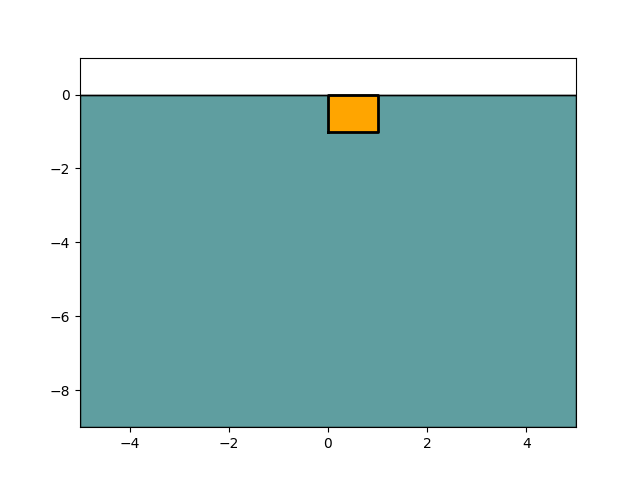

In [2]:
        
def f(x,u):
    ''' x=[d,v,b]
    '''
    d, v, b = x[0], x[1], x[2]
    dv = g - (g*np.max([0.,L+np.min([d,0.])])+v*np.abs(v)*cx/2.)/(1.+.1*b)
    return np.array([v,dv,u])

# input parameters
ech=5.
L=1.
x=np.array([3.,0.,-1.])
dt=.05
#
rho, g, cx = 1000., 9.81, 1.05

#ax=fig.add_subplot(111,aspect='equal')
X=x
for t in np.arange(0,10,dt):
    u=0.
    x+=f(x,u)*dt
    #draw_float(x)
    X = np.vstack((X,x))

drawf = lambda i: draw_float(X[i,:]) # wrapper
#fig=plt.figure(0)
fig, ax = plt.subplots()
anim = animation.FuncAnimation(fig, drawf,frames=X.shape[0], interval=20, blit=False)
HTML(anim.to_html5_video())

## [Link](https://vimeo.com/244356079) to online video


---

## with a control

Sliding mode controler:

- sliding mode surface $s(x,t)=(\partial_{tt} y_d - \partial_{tt} y) 
+ 2(\partial_{t} y_d - \partial_{t} y) + (y_d - y)$, where $y_d$ is the desired depth. $e=y_d-y$ is a measure of error then.

- set u to 1 if $s>0$ and -1 if $s<0$

- Leads to a stable control with a time scale of 1 second.

<IPython.core.display.Javascript object>


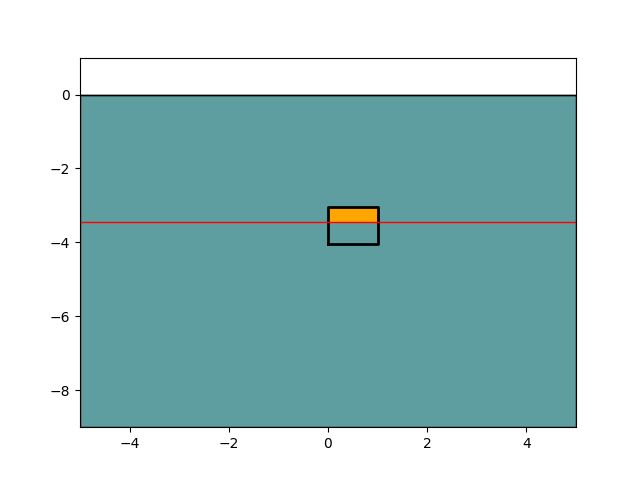

In [4]:
def control(x,d0,d0dot,d0ddot):
    d, v, b = x[0], x[1], x[2]
    return np.sign(d0ddot-(g-(g*L+v*np.abs(v)*cx/2.)/((1.+.1*b)*L)) + 2*(d0dot-v) +(d0-d) )


# input parameters
x=np.array([3.,0.,0.])
#
d0 = 5. # desired depth
d0dot = 0.
d0ddot = 0.

X=x
for t in np.arange(0,10,dt):
    if False:
        d0 = 5. # desired depth
        d0dot = 0.
        d0ddot = 0.
    else:
        d0 = 3. + np.sin(.5*t) # desired depth
        #d0dot = .5*np.cos(.5*t)
        #d0ddot = -.25*np.sin(.5*t)
        # assumes derivates are not known (for an isotherm for example)
        d0dot = 0.
        d0ddot = 0.
    u=control(x,d0,d0dot,d0ddot)
    x+=f(x,u)*dt
    if np.abs(x[2])>1: x[2]=np.sign(x[2])
    #draw_float(x)
    X = np.vstack((X,x))

drawf = lambda i: draw_float(X[i,:],d0=3.+np.sin(.5*i*dt)) # wrapper
fig, ax = plt.subplots()
anim = animation.FuncAnimation(fig, drawf,frames=X.shape[0], interval=20, blit=False)
HTML(anim.to_html5_video())

## [Link](https://vimeo.com/244355842) to online video


In [ ]:
#import gsw
#p = gsw.p_from_z(z,lat.mean())
#SA = gsw.SA_from_SP(s,p, lon, lat)
#CT = gsw.CT_from_pt(SA,t)
#c = gsw.sound_speed(s,t,p)

Viscous drag forces may be expressed as:
$$
\begin{align}
D &= - m \Big [ \delta_3(\omega) \frac{d^2z_r}{dt^2} + \sigma_3(\omega) \frac{dz_r}{dt}  \Big ],
\end{align}
$$
where
$$
\begin{align}
\delta_3(\omega) &= \frac{2}{X} I[ke_1(x)/ke_0(x) e^{i3\pi/4} ] \\
\sigma_3(\omega) &= \frac{2\mu}{a^2X} R[ke_1(x)/ke_0(x) e^{i3\pi/4} ] \\
\end{align}
$$
with $x=a\sqrt{\omega/\mu}$, $a$ the float radius and $\mu\sim10^{−7} m^2/s$.
modified Bessel functions of the second kind.

In [6]:
#from ipywidgets import interact
#interact(drawf, i=(0,X.shape[0]-1))

# call the animator. blit=True means only re-draw the parts that have changed.
#anim = animation.FuncAnimation(fig, drawf,frames=X.shape[0], interval=20, blit=False)
#HTML(anim.to_jshtml())
#HTML(anim.to_html5_video())
#rc('animation', html='html5')